In [132]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

In [133]:
# Constants
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal", "Fraud"]

In [134]:
print(list(dataset.columns))
print(dataset.describe())

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
               Time            V1            V2            V3            V4  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -7.025418e-17  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std    1.000002e+00  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min   -1.996583e+00 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%   -8.552120e-01 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%   -2.131453e-01  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    9.372174e-01  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    1.642058e+00  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            

In [135]:
# Check for null values
print("Any nulls in the dataset:", dataset.isnull().values.any())
print('-------')
print("No. of unique labels:", len(dataset['Class'].unique()))
print("Label values:", dataset.Class.unique())

Any nulls in the dataset: False
-------
No. of unique labels: 2
Label values: [0 1]


In [136]:
# Breakdown of the Normal and Fraud Transactions
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort=True))

-------
Break down of the Normal and Fraud Transactions
Class
0    284315
1       492
Name: count, dtype: int64


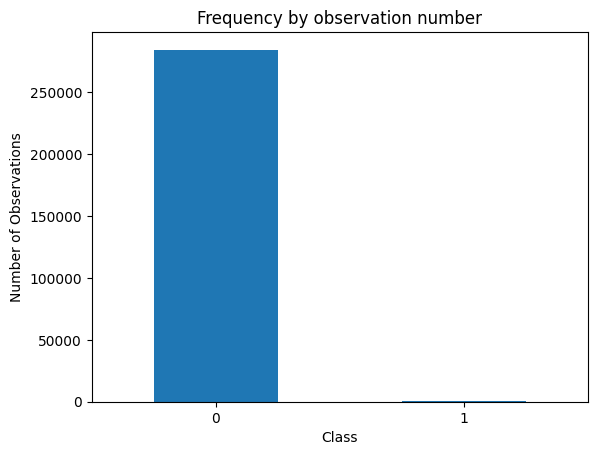

In [137]:
# Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.show()


/home/student/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


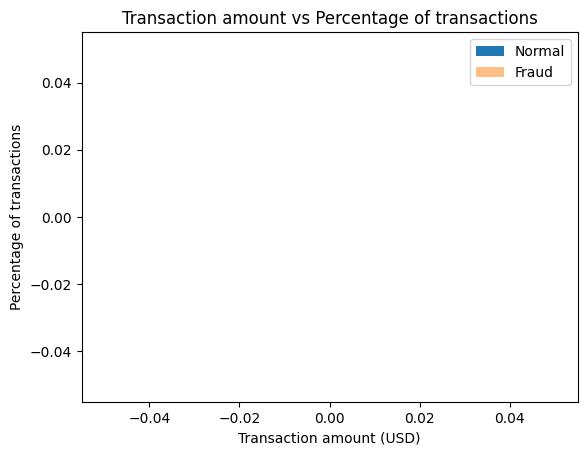

In [138]:
# Visualize transaction amounts
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")
plt.show()

In [139]:
# Save the normal and fraudulent transactions in separate dataframes
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

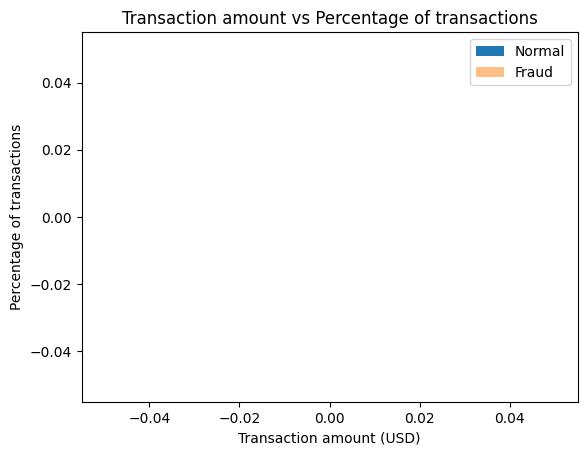

In [140]:
# Visualize transaction amounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions")
plt.show()

In [141]:
# StandardScaler to only Amount and Time columns
sc = StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [142]:
# The last column in the dataset is our target variable
raw_data = dataset.values
labels = raw_data[:, -1]  # 0 for normal, 1 for fraud
data = raw_data[:, 0:-1]

In [143]:
# Split the dataset into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=RANDOM_SEED)


In [144]:
# Normalize the data to have a value between 0 and 1
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)


In [145]:
# Use only normal transactions to train the Autoencoder
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)


In [146]:
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]

In [147]:
print("No. of records in Fraud Train Data =", len(fraud_train_data))
print("No. of records in Normal Train Data =", len(normal_train_data))
print("No. of records in Fraud Test Data =", len(fraud_test_data))
print("No. of records in Normal Test Data =", len(normal_test_data))

No. of records in Fraud Train Data = 389
No. of records in Normal Train Data = 227456
No. of records in Fraud Test Data = 103
No. of records in Normal Test Data = 56859


In [148]:
# Autoencoder parameters
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1]  # Number of columns
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2)
hidden_dim_2 = 4
learning_rate = 1e-7

In [149]:
# Input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim,))

In [150]:
# Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
                                 activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

In [151]:
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

In [152]:
# Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_24 (Dense)            (None, 14)                434       
                                                                 
 dropout_8 (Dropout)         (None, 14)                0         
                                                                 
 dense_25 (Dense)            (None, 7)                 105       
                                                                 
 dense_26 (Dense)            (None, 4)                 32        
                                                                 
 dense_27 (Dense)            (None, 7)                 35        
                                                                 
 dropout_9 (Dropout)         (None, 7)                 0   

In [153]:

# Define the callbacks for checkpoints and early stopping
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                                         mode='min', monitor='val_loss', verbose=2, save_best_only=True)

In [154]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

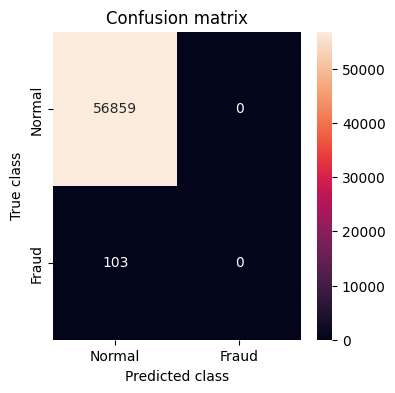

In [155]:
threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True,fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [156]:
# Compile the Autoencoder
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')


In [157]:
# Train the Autoencoder
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(test_data, test_data),
                          verbose=1,
                          callbacks=[cp, early_stop]).history

Epoch 1/50
3496/3554 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.0549
Epoch 1: val_loss improved from inf to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 3s 811us/step - loss: 0.0041 - accuracy: 0.0551 - val_loss: 1.9960e-05 - val_accuracy: 0.2168
Epoch 2/50
 226/3554 [>.............................] - ETA: 2s - loss: 1.9723e-05 - accuracy: 0.0656

/home/student/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3528/3554 [============================>.] - ETA: 0s - loss: 1.9373e-05 - accuracy: 0.0634
Epoch 2: val_loss did not improve from 0.00002
3554/3554 [==============================] - 3s 788us/step - loss: 1.9367e-05 - accuracy: 0.0635 - val_loss: 1.9984e-05 - val_accuracy: 0.2168
Epoch 3/50
3496/3554 [============================>.] - ETA: 0s - loss: 1.9409e-05 - accuracy: 0.0605
Epoch 3: val_loss did not improve from 0.00002
3554/3554 [==============================] - 3s 777us/step - loss: 1.9405e-05 - accuracy: 0.0605 - val_loss: 1.9996e-05 - val_accuracy: 0.0419
Epoch 4/50
3535/3554 [============================>.] - ETA: 0s - loss: 1.9460e-05 - accuracy: 0.0649
Epoch 4: val_loss did not improve from 0.00002
3554/3554 [==============================] - 3s 787us/step - loss: 1.9454e-05 - accuracy: 0.0648 - val_loss: 2.0333e-05 - val_accuracy: 0.0597
Epoch 5/50
3553/3554 [============================>.] - ETA: 0s - loss: 1.9501e-05 - accuracy: 0.0597
Epoch 5: val_loss did not improve

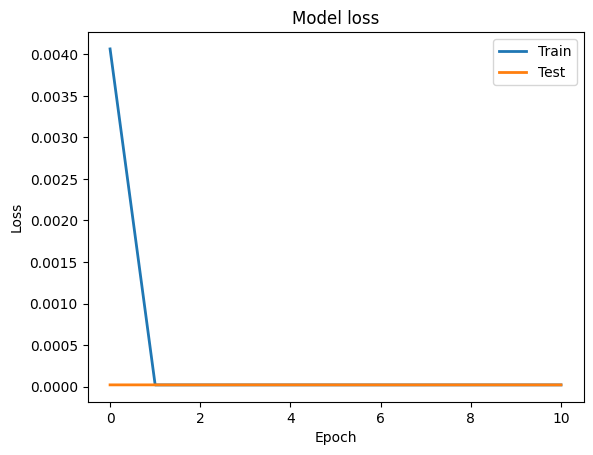

In [158]:
# Plot training and test loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [159]:
# Detect anomalies on test data
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_labels})

1781/1781 [==============================] - 1s 466us/step


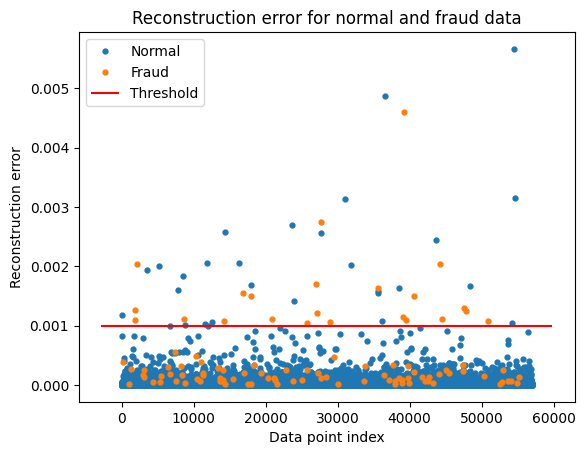

In [160]:
# Plotting the reconstruction error
threshold_fixed = 0.001
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()


In [161]:
# Detect anomalies based on threshold
threshold_fixed = 0.001
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] = pred_y

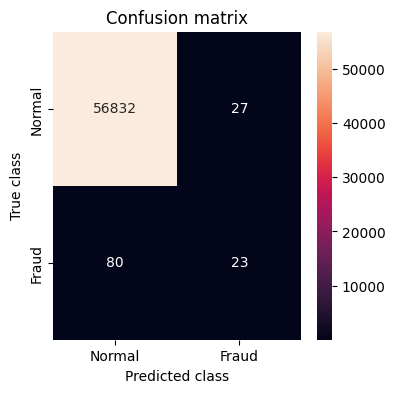

In [162]:
# Confusion matrix
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [163]:

# Print Accuracy, Precision, and Recall
print("Accuracy:", accuracy_score(error_df['True_class'], error_df['pred']))
print("Recall:", recall_score(error_df['True_class'], error_df['pred'], zero_division=0))
print("Precision:", precision_score(error_df['True_class'], error_df['pred'], zero_division=0))

Accuracy: 0.998121554720691
Recall: 0.22330097087378642
Precision: 0.46
